In [6]:
import sys
import json
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines
import pandas as pd

import pipelineloader as pl
pl.config.subject_dir = "/home/vep/RetrospectivePatients/1-Processed/"

sys.path.append("../scripts/")
import onsettimes

sys.path.append("../../ddmisp/")
from util.plot import add_panel_letters

%matplotlib inline

In [2]:
onset = 'INC'
atlas = 'vep'
nreg = 162

## Read data

In [3]:
# Number of observed regions
def get_mapping_results():
    n_obss = []
    n_assigned = np.zeros(20, dtype=int)
    matching = {'sz': 0, 'ns': 0, 'mixsz': 0, 'mixns': 0}
    tspan = []
    
    # Only one per subject
    for i in range(1, 51):
        try:
            filename = glob.glob(f"../run/onset_regions/{onset}/{atlas}/data/id{i:03d}_*.json")[0]
        except IndexError:
            continue
        with open(filename) as fh:
            data = json.load(fh)['regions_onsets']
            
        nobs = 0
        for j, reginfo in enumerate(data):
            n_assigned[len(reginfo)] += 1
            if len(reginfo) > 0:
                nobs += 1
        n_obss.append(nobs)
        
    # All seizures
    for filename in glob.glob(f"../run/onset_regions/{onset}/{atlas}/data/*.json"):
        with open(filename, 'r') as fh:
            data = json.load(fh)['regions_onsets']
        for j, reginfo in enumerate(data):            
            nsz = len([a for a in reginfo if a[3] == "sz"])
            nns = len([a for a in reginfo if a[3] == "ns"])
            if nsz > 0 and nns == 0:
                matching['sz'] += 1
            elif nns > 0 and nsz == 0:
                matching['ns'] += 1
            elif nsz > 0 and nns > 0 and nsz >= nns:
                matching['mixsz'] += 1
            elif nsz > 0 and nns > 0 and nns > nsz:
                matching['mixns'] += 1
                
            if nsz > 0 and nsz >= nns:
                onset_times = [a[4] for a in reginfo if a[3] == "sz"]
                tspan.append(np.max(onset_times) - np.min(onset_times))
        
    return n_obss, n_assigned, matching, np.array(tspan)
    
    
nobs_per_seizure, nchannels_per_region, matching, tspan = get_mapping_results()

In [4]:
def get_fractions_onsets():
    f_channels = []
    f_regions = []
    
    onsets_channels = []
    onsets_regions = []
    
    first_onsets_channels = []
    first_onsets_regions = []
    
    with open(f"../run/clinical_onset_times.json") as fh:
        clinical_onset_times = json.load(fh)
        clin_onsets = {(int(r['sid']), int(r['rid'])): r['onset'] for r in clinical_onset_times}
        
    
    for sid in range(1, 51):
        # Channels
        filename = f"../run/onset_channels/{onset}/id{sid:03d}.json"
        with open(filename) as fh:
            data = json.load(fh)
        for rec in data:
            rid = rec["rid"]
            nsz = len(rec["channels_seizing"])
            nns = len(rec["channels_nonseizing"])
            f_channels.append(nsz/(nsz + nns))
            
            tsz = np.array(rec["onset_times"])
            if len(tsz) > 0:
                # onsets_channels.extend(tsz - np.min(tsz))
                onsets_channels.extend(tsz - clin_onsets[sid, rid])
                first_onsets_channels.append(np.min(tsz) - clin_onsets[sid, rid])
        
        # Regions
        filename = f"../run/onset_regions/{onset}/{atlas}/id{sid:03d}.json"
        with open(filename) as fh:
            data = json.load(fh)
        for rec in data:
            rid = rec["rid"]
            nsz = len(rec["regions_seizing"])
            nns = len(rec["regions_nonseizing"])
            f_regions.append(nsz/(nsz + nns))
            
            tsz = np.array(rec["onset_times"])
            if len(tsz) > 0:
                # onsets_regions.extend(tsz - np.min(tsz))
                onsets_regions.extend(tsz - clin_onsets[sid, rid])
                first_onsets_regions.append(np.min(tsz) - clin_onsets[sid, rid])
    
    return (np.array(f_channels), np.array(f_regions), 
            np.array(onsets_channels), np.array(onsets_regions),
            np.array(first_onsets_channels), np.array(first_onsets_regions))
    
    
f_channels, f_regions, onsets_channels, onsets_regions, fst_channels, fst_regions = get_fractions_onsets()

In [7]:
def get_data_onset_detection(sid, rid, plot_ch):
    subj = pl.Subject(sid)
    rec = subj.seizure_recordings[rid]
    rec.load()
    
    time, data, t_szo, ch_names = onsettimes.get_seizure_data_bip(rec)

    inds = [i for i, ch in enumerate(ch_names) if ch in plot_ch]
    tmask = (time > t_szo - 60) * (time <= t_szo + 60)

    sz_mask, onset_times, plot_artifacts = onsettimes.get_onset_times(
        time[tmask] - t_szo, data[inds][:, tmask], 0.0, plot_ch, 'INC')
    
    return plot_artifacts

plot_artifacts = get_data_onset_detection(24, 3, ["TB2-1", "TB'2-1"])

/home/viktorsip/projects/pipelineloader/pipelineloader/contacts.py:10: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(fl, dtype=None)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.1s finished


## Plotting

In [9]:
def plot_detection_example(ax):
    plt.sca(ax)
    plt.title("Detection")
    
def plot_nobs_per_seizure(ax, nobs):
    plt.sca(ax)
    
    plt.title("Observed regions per subject\n(out of 162)")
    plt.hist(nobs, bins=np.arange(np.min(nobs), np.max(nobs)+2)-0.5, ec='k')
    # plt.hist(nobs)
    plt.xlabel("Number of observed regions")
    plt.ylabel("Count (subjects)")
    
def plot_nchannels_per_region(ax, nchannels):
    plt.sca(ax)
        
    nmax = np.where(nchannels != 0)[0][-1]
    
    plt.title("Channels per region")
    # plt.hist(nchannels, bins=np.arange(0, 22)-0.5)
    plt.bar(np.r_[1:nmax+1], nchannels[1:nmax+1], ec='k', width=1.0)
    plt.xlabel("Number of assigned channels")
    plt.ylabel("Count (regions)")
    plt.xticks(np.r_[1:nmax+1])
    
def plot_matching(ax, matching):
    plt.sca(ax)
    
    sz = matching['sz']
    ns = matching['ns']
    mixs = matching['mixsz']
    mixn = matching['mixns']
    
    plt.bar([0, 2], [sz, mixs+mixn], color='lightcoral',   ec='k', lw=1, label='Seizing')
    plt.bar([1, 2], [ns, mixn],      color='lightskyblue', ec='k', lw=1, label='Non-seizing')
    plt.bar([0, 1, 2], [sz, ns, mixs+mixn], color="None", ec='k', lw=2)
    
    plt.text(0, 500, f"{100 * sz/(sz+ns+mixn+mixs):.1f}%", ha='center')
    plt.text(1, 500, f"{100 * ns/(sz+ns+mixn+mixs):.1f}%", ha='center')
    plt.text(2, 500, f"{100 * (mixn+mixs)/(sz+ns+mixn+mixs):.1f}%", ha='center')
    
    plt.xticks([0, 1, 2], ["All channels\nseizing", "All channels\nnon-seizing", "Some seizing,\nsome non-seizing"],
                fontsize=8)
    plt.ylabel("Count (regions)")
    plt.legend(loc='upper right', title='Region assignment')
    plt.title("Mapping conflicts")
    
def plot_tspan(ax, tspan):
    plt.sca(ax)
    plt.hist(tspan, bins=np.linspace(0, 60, 25), ec='k', fc='lightcoral')
    ax.set_yscale('log')
    plt.ylabel('Count (regions)')
    plt.title("Max onset time difference\nfor a single seizing region")
    plt.xlabel("Difference [s]")
    
    p80, p95 = np.percentile(tspan, [80, 95])
    plt.axvline(p80, color='k')
    plt.axvline(p95, color='k')
    plt.text(p80, 700, " p80", ha='left', va='top')
    plt.text(p95, 700, " p95", ha='left', va='top')
    plt.text(60, 30, f"{100*np.mean(tspan > 60.0):.1f}% →", ha='right', va='center')

In [10]:
def plot_frac_seizing(ax, frac):
    plt.sca(ax)
    plt.hist(frac, bins=np.linspace(0, 1, 11), color='tab:orange', ec='k')
    plt.ylabel("Count (seizures)")
    plt.xticks(np.linspace(0, 1, 6))
    plt.title("Fraction of seizing regions\nin one seizure")
    plt.xlabel("Fraction")

def plot_onset_time_std(ax, tsz, title):
    plt.sca(ax)
    plt.hist(tsz, bins=np.linspace(0, 100, 21), color='tab:orange', ec='k') 
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Count (regions)")
    plt.text(0.96, 0.25, f"{100*np.mean(tsz > 100):.1f}% →", ha='right', va='center', transform=ax.transAxes)    

In [57]:

def plot_onset_detection(ax, method, ch_names, time, t_onset, data,
                         tlp, lpl, lph, logthreshold, szmask, onset_times):
    nch = len(ch_names)
    data -= np.mean(data, axis=1)[:, None]
    
    plt.sca(ax)
    
    for i in range(nch):
        # Raw time series
        preictal_mask = time < t_onset
        scaling = 0.2/np.percentile(np.abs(data[i, preictal_mask]), 95)
        plt.plot(time, scaling*data[i, :] + nch - i - 1, 'k', lw=0.3, zorder=1)

        # band powers
        fac = 0.3
        args = dict(color='r', lw=1, zorder=5)        
        plt.plot(tlp, fac*lpl[i] + nch - i - 1, ls='-',  label="LF log power" if i == 0 else None, **args)
        plt.plot(tlp, fac*lph[i] + nch - i - 1, ls='--', label="HF log power" if i == 0 else None, **args)

        # plt.axhspan(nch-i-1 - fac*logthreshold, nch-i-1 + fac*logthreshold, color='0.75', zorder=-1)
        plt.axhline(nch-i-1, color='0.4', lw=1)
        plt.axhline(nch-i-1+fac*logthreshold, color='0.4', lw=1)

        # Onset time
        if szmask[i]:
            plt.plot([onset_times[i], onset_times[i] + 60.], [nch-i-1.3, nch-i-1.3], lw=5, color='tab:orange', zorder=10)
            # plt.plot([onset_times[i], onset_times[i]], [nch-i-1-0.3, nch-i-1+0.65], lw=2, color='orange', zorder=10)
            # plt.scatter([onset_times[i]], [nch-i-1-0.2], marker='^', color='k', zorder=10)
            plt.text(onset_times[i]+0.2, nch-i-1.38, "Onset", color='tab:orange', ha='center', va='top', fontsize=10)

    # plt.axvline(t_onset, color='gray', ls='--')
    plt.yticks(np.r_[:nch], reversed(ch_names))
    plt.ylim([-1, nch])
    plt.legend(loc='upper left', ncol=2)    
    plt.xlabel("Time [s]")
    plt.title("Onset time detection")
    
        
    ax2 = ax.twinx()
    plt.sca(ax2)
    plt.yticks(np.concatenate([[i, i+fac*logthreshold] for i in range(nch)]),
               np.concatenate([["Baseline", "Threshold"] for i in range(nch)]))
    
    ax.set_ylim([-0.4, nch+0.1])
    ax2.set_ylim([-0.4, nch+0.1])

In [58]:
img_mapping = plt.imread("../etc/mapping.png")

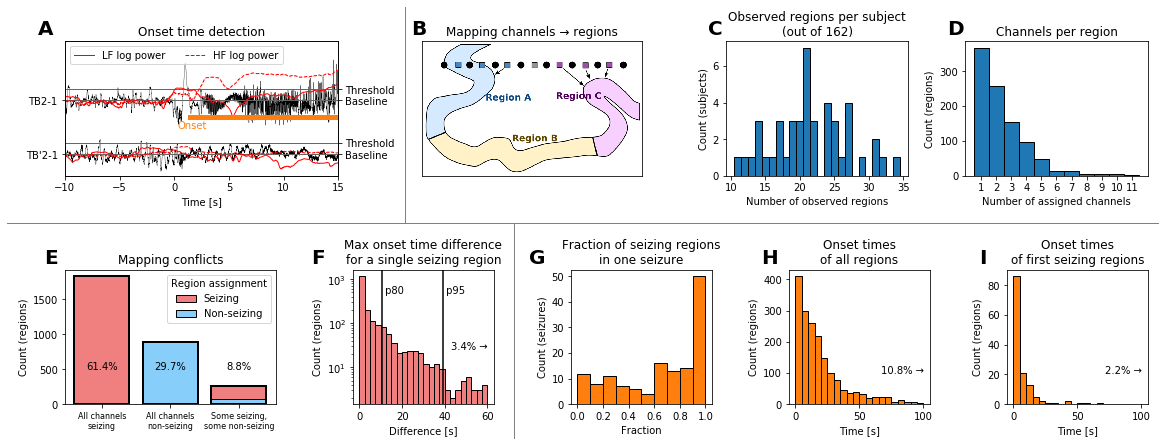

In [59]:
fig = plt.figure(figsize=(16, 6))

gs = gridspec.GridSpec(2, 1, hspace=0.7, left=0.05, right=0.99, top=0.92, bottom=0.08)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, gs[0], wspace=0.25, width_ratios=[3, 3, 2, 2])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, gs[1], wspace=0.5, width_ratios=[1.5, 1, 1, 1, 1])

# Detection
ax0 = plt.subplot(gs1[0])
plot_onset_detection(ax0, **plot_artifacts)
plt.xlim(-10, 15)

# Mapping: sketch
ax1 = plt.subplot(gs1[1])
plt.title("Mapping channels → regions")
plt.imshow(img_mapping, interpolation='none')
plt.xticks([]); plt.yticks([])

# Mapping: structure
ax2 = plt.subplot(gs1[2])
plot_nobs_per_seizure(ax2, nobs_per_seizure)

ax3 = plt.subplot(gs1[3])
plot_nchannels_per_region(ax3, nchannels_per_region)

# Mapping: conflicts
ax4 = plt.subplot(gs2[0])
plot_matching(ax4, matching)

ax5 = plt.subplot(gs2[1])
plot_tspan(ax5, tspan)

# Results
ax6 = plt.subplot(gs2[2])
plot_frac_seizing(ax6, f_regions)

ax7 = plt.subplot(gs2[3])
plot_onset_time_std(ax7, onsets_regions, "Onset times\nof all regions")

ax8 = plt.subplot(gs2[4])
plot_onset_time_std(ax8, fst_regions, "Onset times\nof first seizing regions")


# Annotation and stuff
axbg = plt.axes([0,0,1,1], facecolor=None)
plt.axis('off')
axbg.add_line(lines.Line2D([0, 1], [0.5, 0.5], color='0.5', lw=1))
axbg.add_line(lines.Line2D([0.345, 0.345], [0.5, 1], color='0.5', lw=1))
axbg.add_line(lines.Line2D([0.44, 0.44], [0., 0.5], color='0.5', lw=1))
add_panel_letters(fig, axes=[ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], 
                  xpos=[-0.1, -0.05, -0.1, -0.1, -0.1, -0.3, -0.3, -0.2, -0.2], fontsize=20)


plt.savefig("img/detection-mapping.pdf")